## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
import tensorflow as tf
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
from keras.regularizers import l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drop_rate=0.3, l1_ratio=1e-4, l2_ratio=1e-4, bn_use=False):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
            if bn_use:
                x = BatchNormalization()(x)
            x = keras.layers.Activation("relu")(x)
            x = keras.layers.Dropout(drop_rate)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
            if bn_use:
                x = BatchNormalization()(x)
            x = keras.layers.Activation("relu")(x)
            x = keras.layers.Dropout(drop_rate)(x)
                
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.90
L1_EXP = [0, 1e-4]
L2_EXP = [0, 1e-4]
DROP_EXP = [0, 0.3]
BN_USE = [False, True]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for l1_r, l2_r, d_r, bn_u in itertools.product(L1_EXP, L2_EXP, DROP_EXP, BN_USE ):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %s L1 = %s L2 = %s DR = %s BN = %s" % (LEARNING_RATE, l1_r, l2_r, d_r, bn_u))
    model = build_mlp(input_shape=x_train.shape[1:], drop_rate=d_r, l1_ratio=l1_r, l2_ratio=l2_r, bn_use=bn_u)
    model.summary()
    optimizer = keras.optimizers.adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

    exp_name_tag = "exp-%s-%s-%s-%s" % (str(d_r), str(l1_r), str(l2_r), bn_u)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with LR = 0.001 L1 = 0 L2 = 0 DR = 0 BN = False
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________


50000/50000 [==============================] - 4s 78us/step - loss: 0.7411 - accuracy: 0.7348 - val_loss: 1.6107 - val_accuracy: 0.5242
Epoch 44/50
50000/50000 [==============================] - 4s 79us/step - loss: 0.7292 - accuracy: 0.7385 - val_loss: 1.6458 - val_accuracy: 0.5159
Epoch 45/50
50000/50000 [==============================] - 4s 82us/step - loss: 0.7097 - accuracy: 0.7465 - val_loss: 1.7150 - val_accuracy: 0.5110
Epoch 46/50
50000/50000 [==============================] - 4s 79us/step - loss: 0.7050 - accuracy: 0.7469 - val_loss: 1.6758 - val_accuracy: 0.5244
Epoch 47/50
50000/50000 [==============================] - 4s 75us/step - loss: 0.6892 - accuracy: 0.7552 - val_loss: 1.7554 - val_accuracy: 0.5134
Epoch 48/50
50000/50000 [==============================] - 4s 82us/step - loss: 0.6887 - accuracy: 0.7527 - val_loss: 1.7521 - val_accuracy: 0.5199
Epoch 49/50
50000/50000 [==============================] - 4s 73us/step - loss: 0.6557 - accuracy: 0.7645 - val_loss: 1.7870

50000/50000 [==============================] - 15s 308us/step - loss: 0.1159 - accuracy: 0.9598 - val_loss: 3.3967 - val_accuracy: 0.4699
Epoch 33/50
50000/50000 [==============================] - 16s 312us/step - loss: 0.0914 - accuracy: 0.9694 - val_loss: 3.0190 - val_accuracy: 0.4836
Epoch 34/50
50000/50000 [==============================] - 15s 310us/step - loss: 0.0972 - accuracy: 0.9676 - val_loss: 3.6381 - val_accuracy: 0.4615
Epoch 35/50
50000/50000 [==============================] - 9s 182us/step - loss: 0.1044 - accuracy: 0.9638 - val_loss: 3.4263 - val_accuracy: 0.4554
Epoch 36/50
50000/50000 [==============================] - 6s 130us/step - loss: 0.0980 - accuracy: 0.9673 - val_loss: 3.5923 - val_accuracy: 0.4659
Epoch 37/50
50000/50000 [==============================] - 6s 126us/step - loss: 0.0953 - accuracy: 0.9674 - val_loss: 3.4321 - val_accuracy: 0.4670
Epoch 38/50
50000/50000 [==============================] - 6s 124us/step - loss: 0.0911 - accuracy: 0.9691 - val_lo

Epoch 24/50
50000/50000 [==============================] - 22s 442us/step - loss: 1.6368 - accuracy: 0.4096 - val_loss: 1.5831 - val_accuracy: 0.4417los
Epoch 25/50
50000/50000 [==============================] - 14s 285us/step - loss: 1.6324 - accuracy: 0.4154 - val_loss: 1.5471 - val_accuracy: 0.4585
Epoch 26/50
50000/50000 [==============================] - 23s 451us/step - loss: 1.6345 - accuracy: 0.4089 - val_loss: 1.5859 - val_accuracy: 0.4432ccuracy: 
Epoch 27/50
50000/50000 [==============================] - 11s 214us/step - loss: 1.6206 - accuracy: 0.4182 - val_loss: 1.5767 - val_accuracy: 0.4432
Epoch 28/50
50000/50000 [==============================] - 15s 298us/step - loss: 1.6222 - accuracy: 0.4180 - val_loss: 1.5455 - val_accuracy: 0.4578
Epoch 29/50
50000/50000 [==============================] - 13s 267us/step - loss: 1.6149 - accuracy: 0.4179 - val_loss: 1.5400 - val_accuracy: 0.4608
Epoch 30/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.6171 

50000/50000 [==============================] - 12s 240us/step - loss: 1.1796 - accuracy: 0.5782 - val_loss: 1.4227 - val_accuracy: 0.5001
Epoch 14/50
50000/50000 [==============================] - 12s 235us/step - loss: 1.1523 - accuracy: 0.5912 - val_loss: 1.5133 - val_accuracy: 0.4667
Epoch 15/50
50000/50000 [==============================] - 12s 236us/step - loss: 1.1372 - accuracy: 0.5977 - val_loss: 1.8273 - val_accuracy: 0.3753
Epoch 16/50
50000/50000 [==============================] - 13s 250us/step - loss: 1.1167 - accuracy: 0.6019 - val_loss: 1.4996 - val_accuracy: 0.4679
Epoch 17/50
50000/50000 [==============================] - 11s 221us/step - loss: 1.0992 - accuracy: 0.6088 - val_loss: 1.5457 - val_accuracy: 0.4527
Epoch 18/50
50000/50000 [==============================] - 12s 234us/step - loss: 1.0759 - accuracy: 0.6187 - val_loss: 1.5097 - val_accuracy: 0.4663
Epoch 19/50
50000/50000 [==============================] - 12s 233us/step - loss: 1.0557 - accuracy: 0.6278 - va

50000/50000 [==============================] - 10s 208us/step - loss: 1.6116 - accuracy: 0.4443 - val_loss: 1.5864 - val_accuracy: 0.4531
Epoch 5/50
50000/50000 [==============================] - 9s 187us/step - loss: 1.5649 - accuracy: 0.4604 - val_loss: 1.5982 - val_accuracy: 0.4504
Epoch 6/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.5266 - accuracy: 0.4722 - val_loss: 1.5473 - val_accuracy: 0.4709
Epoch 7/50
50000/50000 [==============================] - 12s 244us/step - loss: 1.4957 - accuracy: 0.4829 - val_loss: 1.5391 - val_accuracy: 0.4721A: 0s - loss: 1.4951 - 
Epoch 8/50
50000/50000 [==============================] - 18s 367us/step - loss: 1.4726 - accuracy: 0.4947 - val_loss: 1.5490 - val_accuracy: 0.4626
Epoch 9/50
50000/50000 [==============================] - 15s 308us/step - loss: 1.4492 - accuracy: 0.4995 - val_loss: 1.4994 - val_accuracy: 0.4852
Epoch 10/50
50000/50000 [==============================] - 12s 237us/step - loss: 1.4284 - accu

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 16s 311us/step - loss: 1.7594 - accuracy: 0.4274 - val_loss: 2.1933 - val_accuracy: 0.2763
Epoch 2/50
50000/50000 [==============================] - 9s 188us/step - loss: 1.5195 - accuracy: 0.5110 - val_loss: 2.1047 - val_accuracy: 0.3240
Epoch 3/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.4074 - accuracy: 0.5517 - val_loss: 2.0524 - val_accuracy: 0.3363
Epoch 4/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.3299 - accuracy: 0.5843 - val_loss: 2.0286 - val_accuracy: 0.3390
Epoch 5/50
50000/50000 [==============================] - 9s 189us/step - loss: 1.2602 - accuracy: 0.6088 - val_loss: 2.3420 - val_accuracy: 0.3144
Epoch 6/50
50000/50000 [==============================] - 14s 276us/step - loss: 1.2042 - accuracy: 0.6310 - val_loss: 2.0001 - val_accuracy: 0.3794
Epoch 7/50
50000/50000 [==============================] - 18

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 26s 522us/step - loss: 2.1997 - accuracy: 0.2195 - val_loss: 1.9627 - val_accuracy: 0.3285
Epoch 2/50
50000/50000 [==============================] - 20s 400us/step - loss: 1.9917 - accuracy: 0.3005 - val_loss: 1.8639 - val_accuracy: 0.3580
Epoch 3/50
50000/50000 [==============================] - 17s 333us/step - loss: 1.9224 - accuracy: 0.3240 - val_loss: 1.8426 - val_accuracy: 0.3735
Epoch 4/50
50000/50000 [==============================] - 18s 351us/step - loss: 1.8819 - accuracy: 0.3364 - val_loss: 1.7832 - val_accuracy: 0.3905
Epoch 5/50
50000/50000 [==============================] - 14s 279us/step - loss: 1.8352 - accuracy: 0.3474 - val_loss: 1.7224 - val_accuracy: 0.4043
Epoch 6/50
50000/50000 [==============================] - 15s 310us/step - loss: 1.8065 - accuracy: 0.3597 - val_loss: 1.7164 - val_accuracy: 0.4131
Epoch 7/50
50000/50000 [==============================] 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 17s 341us/step - loss: 2.0510 - accuracy: 0.3259 - val_loss: 2.0865 - val_accuracy: 0.3054
Epoch 2/50
50000/50000 [==============================] - 16s 327us/step - loss: 1.7759 - accuracy: 0.4165 - val_loss: 2.0969 - val_accuracy: 0.2968
Epoch 3/50
50000/50000 [==============================] - 14s 285us/step - loss: 1.6828 - accuracy: 0.4497 - val_loss: 1.7601 - val_accuracy: 0.4250
Epoch 4/50
50000/50000 [==============================] - 15s 292us/step - loss: 1.6140 - accuracy: 0.4746 - val_loss: 1.8150 - val_accuracy: 0.3927
Epoch 5/50
50000/50000 [==============================] - 17s 331us/step - loss: 1.5703 - accuracy: 0.4908 - val_loss: 1.8311 - val_accuracy: 0.3816acy: 0.49 -
Epoch 6/50
50000/50000 [==============================] - 24s 471us/step - loss: 1.5382 - accuracy: 0.4989 - val_loss: 1.7723 - val_accuracy: 0.4103
Epoch 7/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 214us/step - loss: 3.6294 - accuracy: 0.3057 - val_loss: 2.5824 - val_accuracy: 0.3564s - loss: 3.696
Epoch 2/50
50000/50000 [==============================] - 9s 182us/step - loss: 2.3196 - accuracy: 0.3761 - val_loss: 2.1551 - val_accuracy: 0.3869
Epoch 3/50
50000/50000 [==============================] - 9s 184us/step - loss: 2.0845 - accuracy: 0.3958 - val_loss: 2.1870 - val_accuracy: 0.3415
Epoch 4/50
50000/50000 [==============================] - 10s 191us/step - loss: 1.9781 - accuracy: 0.4099 - val_loss: 1.9107 - val_accuracy: 0.4182
Epoch 5/50
50000/50000 [==============================] - 15s 298us/step - loss: 1.8845 - accuracy: 0.4249 - val_loss: 1.8395 - val_accuracy: 0.4368
Epoch 6/50
50000/50000 [==============================] - 23s 466us/step - loss: 1.8278 - accuracy: 0.4354 - val_loss: 1.7841 - val_accuracy: 0.4521
Epoch 7/50
50000/50000 [===================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 13s 269us/step - loss: 4.3828 - accuracy: 0.4251 - val_loss: 3.6422 - val_accuracy: 0.3006
Epoch 2/50
50000/50000 [==============================] - 12s 243us/step - loss: 2.7620 - accuracy: 0.4707 - val_loss: 3.1703 - val_accuracy: 0.2513
Epoch 3/50
50000/50000 [==============================] - 13s 253us/step - loss: 2.4558 - accuracy: 0.4849 - val_loss: 2.8794 - val_accuracy: 0.2940
Epoch 4/50
50000/50000 [==============================] - 11s 218us/step - loss: 2.2831 - accuracy: 0.4989 - val_loss: 2.7958 - val_accuracy: 0.2798
Epoch 5/50
50000/50000 [==============================] - 12s 235us/step - loss: 2.1483 - accuracy: 0.5135 - val_loss: 3.1043 - val_accuracy: 0.2530
Epoch 6/50
50000/50000 [==============================] - 13s 270us/step - loss: 2.0425 - accuracy: 0.5266 - val_loss: 2.5652 - val_accuracy: 0.3444
Epoch 7/50
50000/50000 [==============================] 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 155us/step - loss: 3.8275 - accuracy: 0.2222 - val_loss: 2.6788 - val_accuracy: 0.2844
Epoch 2/50
50000/50000 [==============================] - 7s 150us/step - loss: 2.4797 - accuracy: 0.2944 - val_loss: 2.3077 - val_accuracy: 0.3406
Epoch 3/50
50000/50000 [==============================] - 9s 179us/step - loss: 2.2981 - accuracy: 0.3154 - val_loss: 2.1000 - val_accuracy: 0.3694
Epoch 4/50
50000/50000 [==============================] - 12s 238us/step - loss: 2.1892 - accuracy: 0.3279 - val_loss: 2.0593 - val_accuracy: 0.3660- loss: 2.1894 - accuracy: 0.
Epoch 5/50
50000/50000 [==============================] - 15s 290us/step - loss: 2.1005 - accuracy: 0.3355 - val_loss: 1.9997 - val_accuracy: 0.3751
Epoch 6/50
50000/50000 [==============================] - 15s 294us/step - loss: 2.0585 - accuracy: 0.3359 - val_loss: 1.9453 - val_accuracy: 0.3985
Epoch 7/50
50000/50000 [======

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 21s 424us/step - loss: 4.7013 - accuracy: 0.3270 - val_loss: 3.8549 - val_accuracy: 0.1838
Epoch 2/50
50000/50000 [==============================] - 19s 372us/step - loss: 3.0075 - accuracy: 0.3915 - val_loss: 2.9199 - val_accuracy: 0.3910
Epoch 3/50
50000/50000 [==============================] - 17s 344us/step - loss: 2.6970 - accuracy: 0.4057 - val_loss: 2.8646 - val_accuracy: 0.3132
Epoch 4/50
50000/50000 [==============================] - 11s 227us/step - loss: 2.5336 - accuracy: 0.4181 - val_loss: 2.7436 - val_accuracy: 0.3329
Epoch 5/50
50000/50000 [==============================] - 12s 236us/step - loss: 2.4110 - accuracy: 0.4302 - val_loss: 2.7052 - val_accuracy: 0.2997
Epoch 6/50
50000/50000 [==============================] - 17s 340us/step - loss: 2.3312 - accuracy: 0.4341 - val_loss: 2.7904 - val_accuracy: 0.2413
Epoch 7/50
50000/50000 [==============================] 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 237us/step - loss: 3.9408 - accuracy: 0.2904 - val_loss: 2.8344 - val_accuracy: 0.3513
Epoch 2/50
50000/50000 [==============================] - 9s 180us/step - loss: 2.4741 - accuracy: 0.3766 - val_loss: 2.2188 - val_accuracy: 0.3924
Epoch 3/50
50000/50000 [==============================] - 13s 257us/step - loss: 2.1369 - accuracy: 0.3909 - val_loss: 2.1348 - val_accuracy: 0.3746
Epoch 4/50
50000/50000 [==============================] - 18s 367us/step - loss: 2.0125 - accuracy: 0.4089 - val_loss: 2.0411 - val_accuracy: 0.3928
Epoch 5/50
50000/50000 [==============================] - 16s 328us/step - loss: 1.9362 - accuracy: 0.4193 - val_loss: 1.9645 - val_accuracy: 0.3933
Epoch 6/50
50000/50000 [==============================] - 14s 281us/step - loss: 1.8831 - accuracy: 0.4283 - val_loss: 1.8732 - val_accuracy: 0.4330
Epoch 7/50
50000/50000 [==============================] -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 20s 397us/step - loss: 4.4016 - accuracy: 0.4236 - val_loss: 3.6552 - val_accuracy: 0.2291
Epoch 2/50
50000/50000 [==============================] - 22s 432us/step - loss: 2.7632 - accuracy: 0.4682 - val_loss: 3.1205 - val_accuracy: 0.2796
Epoch 3/50
50000/50000 [==============================] - 22s 442us/step - loss: 2.4581 - accuracy: 0.4828 - val_loss: 3.0147 - val_accuracy: 0.2706
Epoch 4/50
50000/50000 [==============================] - 21s 414us/step - loss: 2.2757 - accuracy: 0.4992 - val_loss: 3.1425 - val_accuracy: 0.2145ss: 2.2847 - accuracy:  - ETA: 2s - loss: 2.2836 -  - ETA
Epoch 5/50
50000/50000 [==============================] - 21s 420us/step - loss: 2.1396 - accuracy: 0.5137 - val_loss: 2.8388 - val_accuracy: 0.3158loss: 2.1485 - accuracy: 0. - ETA: 3s - loss: 2.1
Epoch 6/50
50000/50000 [==============================] - 12s 234us/step - loss: 2.0374 - accuracy:

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 240us/step - loss: 3.9231 - accuracy: 0.2223 - val_loss: 2.6726 - val_accuracy: 0.2812
Epoch 2/50
50000/50000 [==============================] - 17s 332us/step - loss: 2.4927 - accuracy: 0.2907 - val_loss: 2.3463 - val_accuracy: 0.3181
Epoch 3/50
50000/50000 [==============================] - 15s 308us/step - loss: 2.2857 - accuracy: 0.3148 - val_loss: 2.1305 - val_accuracy: 0.3589
Epoch 4/50
50000/50000 [==============================] - 22s 438us/step - loss: 2.1694 - accuracy: 0.3292 - val_loss: 2.0351 - val_accuracy: 0.3715
Epoch 5/50
50000/50000 [==============================] - 19s 379us/step - loss: 2.1039 - accuracy: 0.3344 - val_loss: 1.9464 - val_accuracy: 0.3919
Epoch 6/50
50000/50000 [==============================] - 21s 426us/step - loss: 2.0426 - accuracy: 0.3433 - val_loss: 1.9457 - val_accuracy: 0.3828
Epoch 7/50
50000/50000 [==============================] 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 19s 389us/step - loss: 4.7998 - accuracy: 0.3292 - val_loss: 3.8463 - val_accuracy: 0.2224
Epoch 2/50
50000/50000 [==============================] - 18s 358us/step - loss: 3.0360 - accuracy: 0.3916 - val_loss: 3.3514 - val_accuracy: 0.2214
Epoch 3/50
50000/50000 [==============================] - 18s 356us/step - loss: 2.6973 - accuracy: 0.4078 - val_loss: 2.8286 - val_accuracy: 0.3206
Epoch 4/50
50000/50000 [==============================] - 18s 368us/step - loss: 2.5288 - accuracy: 0.4188 - val_loss: 2.7431 - val_accuracy: 0.3193
Epoch 5/50
50000/50000 [==============================] - 19s 372us/step - loss: 2.4064 - accuracy: 0.4284 - val_loss: 2.7138 - val_accuracy: 0.2783
Epoch 6/50
50000/50000 [==============================] - 18s 355us/step - loss: 2.3203 - accuracy: 0.4350 - val_loss: 2.6153 - val_accuracy: 0.2929
Epoch 7/50
50000/50000 [==============================] 

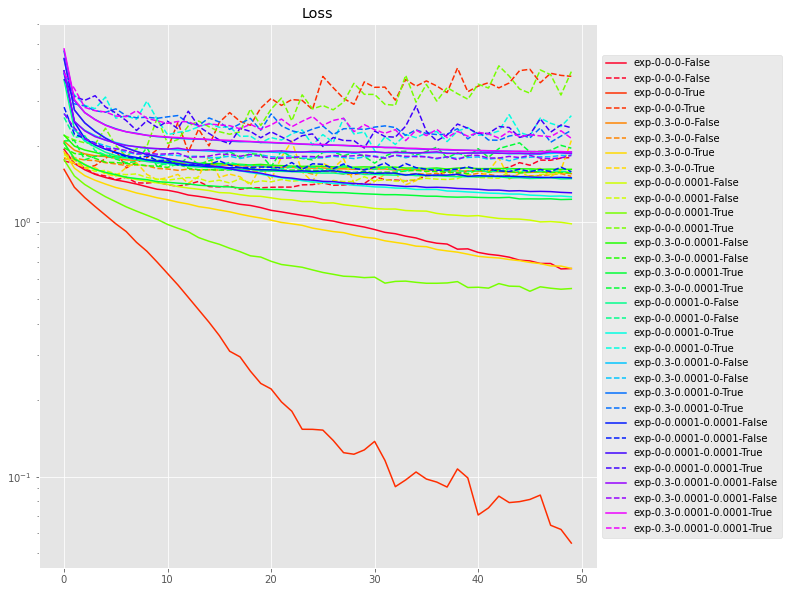

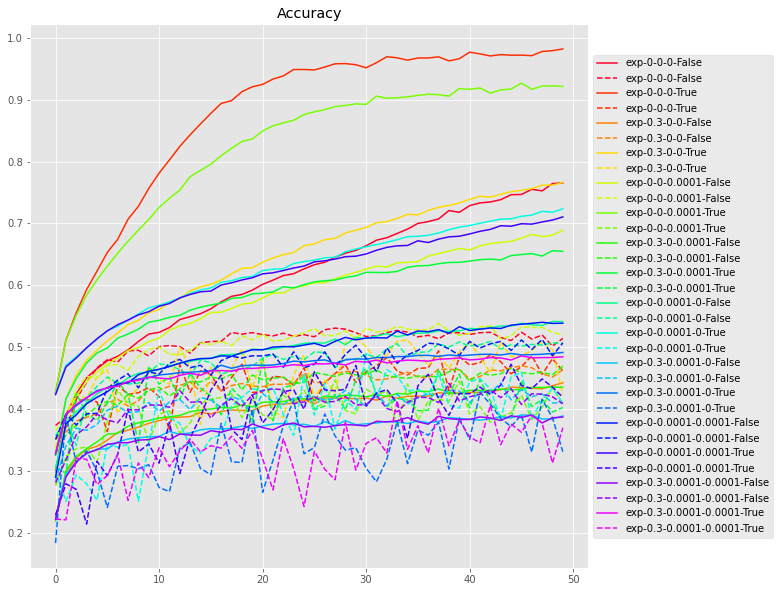

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
"""Code Here
將結果繪出
"""
    
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
#color_bar = ["r", "g", "b", "c", "y", "m", "k", "w"]

plt.figure(figsize=(10,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(10,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()